In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
dpath = os.path.join('.', 'data')
dat_file = os.path.join(dpath, 'sdata.csv')
plt.style.use('seaborn-whitegrid')

# Расчет плоских выделенных элементов оболочек на основе нелинейной деформационной модели

## Параметры расчета

In [2]:
lim_st = '1_st'
iF = 9
dur = 'short'
gb_3 = 1.0
v=0.0

In [3]:
print("Предельное состояние : ", lim_st)
print("Нагружение L/C       : ", iF)
print("Длительность нагрузки: ", dur)
print("Коэффициент gb3      : ", gb_3)
print("Коэффициент Пуассона : ", v)

Предельное состояние :  1_st
Нагружение L/C       :  9
Длительность нагрузки:  short
Коэффициент gb3      :  1.0
Коэффициент Пуассона :  0.0


In [4]:
def prp():
    mat = pd.read_csv('materials.csv', sep=';')
    dat = pd.read_csv(dat_file, sep=';')
    if lim_st == '1_st':
        gb = 1.0
        gbt = 1.0
        gs = 1.0
        gb3 = gb_3
        if dur == 'long':
            gb1 = 0.9
        else:
            gb1 = 1.0
    else:
        gb1 = 1.0
        gb = 1.3
        gbt = 1.5
        gs = 1.15
        gb3 = 1.0
    pr = pd.merge(dat,  mat)
    concr = pr[pr['T'] == 'concrete']
    steel = pr[pr['T'] == 'rebar']
    grade_b = concr['Grade'].values
    grade_s = steel['Grade'].values
    e_2 = pr['eps2'].values
    e_0 = pr['eps0'].values
    e_1 = pr['eps1'].values
    e1 = pr['epst1'].values
    e0 = pr['epst0'].values
    e2 = pr['epst2'].values
    Rc = pd.concat([concr['Rc']*gb*gb1* gb3,  steel['Rc']]).values
    S_1 = pr['Sc1'].values
    S1 = pr['St1'].values
    Rt = pd.concat([concr['Rt']*gbt*gb1,  steel['Rt'] *  gs]).values
    E = pr['E'].values
    ce_2 = e_2[pr['T'] == 'concrete']
    ce_0 = e_0[pr['T'] == 'concrete']
    ce_1 = e_1[pr['T'] == 'concrete']
    ce1 = e1[pr['T'] == 'concrete']
    ce0 = e0[pr['T'] == 'concrete']
    ce2 = e2[pr['T'] == 'concrete']
    cS_1 = S_1[pr['T'] == 'concrete']
    cS1 = S1[pr['T'] == 'concrete']
    cRc = Rc[pr['T'] == 'concrete']
    cRt = Rt[pr['T'] == 'concrete']
    cE = E[pr['T'] == 'concrete']
    re_2 = e_2[pr['T'] == 'rebar']
    re_0 = e_0[pr['T'] == 'rebar']
    re_1 = e_1[pr['T'] == 'rebar']
    re1 = e1[pr['T'] == 'rebar']
    re0 = e0[pr['T'] == 'rebar']
    re2 = e2[pr['T'] == 'rebar']
    rS_1 = S_1[pr['T'] == 'rebar']
    rS1 = S1[pr['T'] == 'rebar']
    rRc = Rc[pr['T'] == 'rebar']
    rRt = Rt[pr['T'] == 'rebar']
    rE = E[pr['T'] == 'rebar']
    return ce_2,ce_0,ce_1,ce1,ce0,ce2,cS_1,cS1,cRc,cRt,cE,re_2,re_0,re_1,re1,re0,re2,rS_1,rS1,rRc,rRt,rE,\
    dat,mat,pr,grade_b,grade_s,e_2,e_0,e_1,e1,e0,e2,S_1,S1,Rc,Rt,E,concr,steel,gs

In [5]:
def chgprop(steel, concr,gs):
    R0 = np.zeros(len(concr))
    S1_s = steel['St1'].values
    Rt_s = steel['Rt'].values * gs
    S1 = np.append(R0, S1_s)
    Rt = np.append(R0, Rt_s)
    cS1 = R0
    cRt = R0
    return S1, Rt, cS1, cRt

In [6]:
ce_2,ce_0,ce_1,ce1,ce0,ce2,cS_1,cS1,cRc,cRt,cE,re_2,re_0,re_1,re1,re0,re2,rS_1,rS1,rRc,rRt,rE,\
dat,mat,pr,grade_b,grade_s,e_2,e_0,e_1,e1,e0,e2,S_1,S1,Rc,Rt,E,concr,steel,gs = prp()
if lim_st == '1_st':
    S1, Rt, cS1, cRt = chgprop(steel, concr,gs)
pl1 = np.eye(3)
t = concr.A.values
Zb = concr.Z.values
K = len(Zb)
v0_1 = np.ones(K)*v
Eb_ = concr.E
E_b = np.stack((Eb_, Eb_), axis=-1)
plb = np.zeros((K, 3, 6))
for i in range(0, K):
    pl2 = pl1 * Zb[i]
    plb[i, :, :] = np.hstack((pl1, pl2))
alpha = np.radians(steel['alpha'].values)
As = steel.A.values
Zs = steel.Z.values
ns = len(Zs)
E_s = steel.E.values
pls = np.zeros((ns, 3, 6))
for i in range(0, ns):
    pl2 = np.eye(3) * Zs[i]
    pls[i, :, :] = np.hstack((pl1, pl2))

### База материалов

In [7]:
mat.head(np.size(mat))

,Grade,eps2,eps0,eps1,epst1,epst0,epst2,Rc,Sc1,St1,Rt,E,T
0,B15,-0.0035,-0.002000,-0.000212,0.000019,0.000100,0.00015,-8.5,-5.1,0.45,0.75,24000,concrete
1,B20,-0.0035,-0.002000,-0.000251,0.000020,0.000100,0.00015,-11.5,-6.9,0.54,0.90,27500,concrete
2,B25,-0.0035,-0.002000,-0.000290,0.000021,0.000100,0.00015,-14.5,-8.7,0.63,1.05,30000,concrete
3,B30,-0.0035,-0.002000,-0.000314,0.000021,0.000100,0.00015,-17.0,-10.2,0.69,1.15,32500,concrete
4,B35,-0.0035,-0.002000,-0.000339,0.000023,0.000100,0.00015,-19.5,-11.7,0.78,1.30,34500,concrete
5,B40,-0.0035,-0.002000,-0.000367,0.000023,0.000100,0.00015,-22.0,-13.2,0.84,1.40,36000,concrete
6,B45,-0.0035,-0.002000,-0.000405,0.000024,0.000100,0.00015,-25.0,-15.0,0.90,1.50,37000,concrete
7,B50,-0.0035,-0.002000,-0.000434,0.000025,0.000100,0.00015,-27.5,-16.5,0.96,1.60,38000,concrete
8,B55,-0.0035,-0.002000,-0.000462,0.000026,0.000100,0.00015,-30.0,-18.0,1.02,1.70,39000,concrete
9,B60,-0.0035,-0.002000,-0.000501,0.000027,0.000100,0.00015,-33.0,-19.8,1.08,1.80,39500,concrete


## Нагрузки

In [8]:
loads_file = os.path.join(dpath, 'sloads.csv')
if lim_st == '1_st':
    head = ['Nxx', 'Nyy', 'Nxy', 'Mxx', 'Myy', 'Mxy']
elif lim_st == '2_st' and dur == 'short':
    head = ['Nxx2', 'Nyy2', 'Nxy2', 'Mxx2', 'Myy2', 'Mxy2']
else:
    head = ['Nxx2l', 'Nyy2l', 'Nxy2l', 'Mxx2l', 'Myy2l', 'Mxy2l']
all_loads = pd.read_csv(loads_file, sep=';')
loads = pd.read_csv(loads_file, usecols=head, sep=';')

### Все нагрузки

In [9]:
all_loads.head(np.size(all_loads))

,Nxx,Nyy,Nxy,Mxx,Myy,Mxy,Nxx2,Nyy2,Nxy2,Mxx2,Myy2,Mxy2,Nxx2l,Nyy2l,Nxy2l,Mxx2l,Myy2l,Mxy2l
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,980,0,0,0,0,0,784,0,0,0,0,0,392,0,0,0,0,0
2,0,800,0,0,0,0,0,640,0,0,0,0,0,320,0,0,0,0
3,-8000,0,0,0,0,0,-6400,0,0,0,0,0,-3200,0,0,0,0,0
4,0,-10000,0,0,0,0,0,-8000,0,0,0,0,0,-4000,0,0,0,0
5,0,0,0,350,0,0,0,0,0,280,0,0,0,0,0,140,0,0
6,0,0,0,0,-400,0,0,0,0,0,-320,0,0,0,0,0,-160,0
7,-100,0,0,350,0,0,-80,0,0,280,0,0,-40,0,0,140,0,0
8,-800,-800,400,0,0,0,-640,-640,320,0,0,0,-320,-320,160,0,0,0
9,-100,100,0,300,300,50,-80,80,0,240,240,40,-40,40,0,120,120,20


### Нагрузки для расчета

In [10]:
loads.head(np.size(loads))

,Nxx,Nyy,Nxy,Mxx,Myy,Mxy
0,0,0,0,0,0,0
1,980,0,0,0,0,0
2,0,800,0,0,0,0
3,-8000,0,0,0,0,0
4,0,-10000,0,0,0,0
5,0,0,0,350,0,0
6,0,0,0,0,-400,0
7,-100,0,0,350,0,0
8,-800,-800,400,0,0,0
9,-100,100,0,300,300,50


In [11]:
def sigma(e, e_2, e_0, e_1, e1, e0, e2, S_1, S1, Rc, Rt, E):
    if e_0 >= e >= e_2:
        S = Rc
    elif e_0 < e < e_1:
        S = ((1 - S_1 / Rc) * (e - e_1)/(e_0 - e_1) + S_1/Rc)*Rc
    elif e_1 <= e < 0.0:
        S = E * e
    elif 0.0 < e <= e1 and S1 != 0.0:
        S = E * e
    elif e1 < e < e0 and Rt != 0.0:
        S = ((1 - S1 / Rt) * (e - e1)/(e0 - e1) + S1 / Rt) * Rt
    elif e0 <= e <= e2:
        S = Rt
    else:
        S = 0.0
    return S

In [12]:
vsigma = np.vectorize(sigma)

In [13]:
def strainstress(i, x, y, grade):
        fig, ax = plt.subplots()
        ax.plot(x, y)
        ax.set_xlabel('Strain')
        ax.set_ylabel('Stress, MPa')
        plt.title('Strain-Stress '+grade)
        ax.annotate(round(y[1], 3), (x[1], y[1]), ha='center')
        ax.annotate(round(y[2], 3), (x[2], y[2]), ha='right')
        ax.annotate(round(y[3], 3), (x[3], y[3]), ha='right')
        ax.annotate(round(y[4], 3), (x[4], y[4]), ha='right')
        ax.annotate(round(y[5], 3), (x[5], y[5]), ha='left')
        ax.scatter(x, y, c='red', alpha=0.5)
        plt.show()

In [14]:
def cstrainstress():
    i=0
    x = [ce_2[i], ce_0[i], ce_1[i], 0.0, ce1[i], ce0[i], ce2[i]]
    y = vsigma(x, ce_2[i], ce_0[i], ce_1[i], ce1[i], ce0[i], ce2[i], cS_1[i], cS1[i], cRc[i], cRt[i], cE[i])
    strainstress(i, x, y, grade_b[i])

In [15]:
def rstrainstress():
    i=0
    x = [re_2[i], re_0[i], re_1[i], 0.0, re1[i], re0[i], re2[i]]
    y = vsigma(x, re_2[i], re_0[i], re_1[i], re1[i], re0[i], re2[i], rS_1[i], rS1[i], rRc[i], rRt[i], rE[i])
    strainstress(i, x, y, grade_s[i])

## Материалы

### Характеристики сечения

In [16]:
prps = np.transpose(np.vstack((e_2, e_0, e_1, e1, e0, e2, S_1, S1, Rc, Rt, E)))
sprop = pd.DataFrame(data=prps, columns=['e_2','e_0','e_1','e1','e0','e2','S_1','S1','Rc','Rt','E'])
wprop = pd.concat([dat, sprop], axis=1)
wprop.head(np.size(wprop))

,Grade,Z,A,n,alpha,e_2,e_0,e_1,e1,e0,e2,S_1,S1,Rc,Rt,E
0,B60,0.250,0.000000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
1,B60,0.240,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
2,B60,0.220,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
3,B60,0.200,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
4,B60,0.180,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
5,B60,0.160,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
6,B60,0.140,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
7,B60,0.120,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
8,B60,0.100,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0
9,B60,0.080,0.020000,1,0,-0.0035,-0.002,-0.000501,0.000027,0.000100,0.00015,-19.8,0.0,-33.0,0.0,39500.0


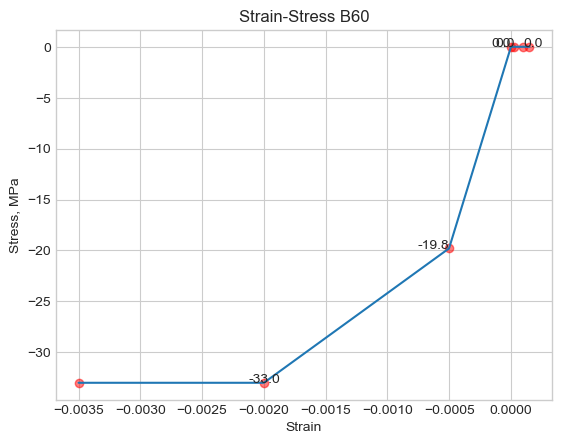

In [17]:
cstrainstress()

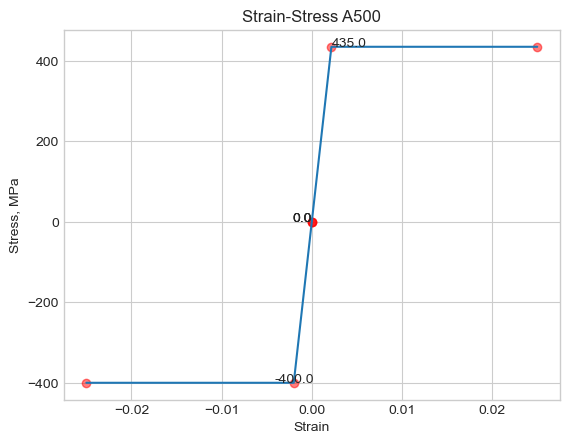

In [18]:
rstrainstress()

In [19]:
def v_b(K, Sb, eps1, eps2):
    vb = np.ones((K, 2))
    for i in range(0, K):
        if eps1[i] != 0:
            vb[i, 0] = Sb[i][0] / E_b[i][0]/eps1[i]
        else:
            vb[i, 0] = 1.0
        if eps2[i] != 0:
            vb[i, 1] = Sb[i][1] / E_b[i][1] / eps2[i]
        else:
            vb[i, 1] = 1.0
    return vb

In [20]:
def sxyb(K, orientation, Sb):
    c = np.cos(orientation)
    s = np.sin(orientation)
    Sxyb = np.zeros((K, 3, 1))
    for i in range(0, K):
        Cb = np.array(
            [[c[i] ** 2, s[i] ** 2], [s[i] ** 2, c[i] ** 2], [s[i] * c[i], -s[i] * c[i]]])
        Sxyb[i][:, :] = Cb @ Sb[i][:, :]
    return Sxyb

In [21]:
def conc(u, v01, v10):
    vv = 1-v01*v10
    epsb = (plb @ u).reshape(K, 3, 1)
    exx = epsb[:, 0].reshape(K)
    eyy = epsb[:, 1].reshape(K)
    gxy = epsb[:, 2].reshape(K)
    ee1 = exx + eyy
    ee2 = exx - eyy
    emax = (ee1/2 + np.sqrt((ee2 / 2) ** 2 + (gxy/2) ** 2))
    emin = (ee1/2 - np.sqrt((ee2 / 2) ** 2 + (gxy/2) ** 2))
    eps1 = (emax + v01*emin)/vv
    eps2 = (v10*emax + emin)/vv
    orientation = 0.5 * np.arctan2(gxy, ee2)
    kRb = np.ones(K)
    for i in range(0, K):
        if eps1[i] > 0.002:
            kRb[i] = 1.0 / (0.8 + 100 * eps1[i])
        else:
            kRb[i] = 1.0
    Sb = np.vstack((vsigma(eps1, ce_2, ce_0, ce_1, ce1, ce0, ce2, cS_1, cS1, cRc, cRt, cE),
    vsigma(eps2, ce_2, ce_0, ce_1, ce1, ce0, ce2, cS_1, cS1, cRc, cRt, cE))).transpose().reshape(K, 2, 1)
    vb = v_b(K, Sb, eps1, eps2)
    Sxyb = sxyb(K, orientation, Sb)
    return vb, Sb, Sxyb, orientation, eps1, eps2

In [22]:
def cQb(E_b, v01):
    Qb = np.zeros((K, 3, 3))
    G01 = np.zeros(K)
    v10 = np.zeros(K)
    for i in range(0, K):
        if E_b[i, 0] != 0.0:
            v10[i] = E_b[i, 1]*v01[i]/E_b[i, 0]
        else:
            v10[i] = 0.0
        G01[i] = Eb_[i]/(2*(1+v10[i]))
    v01 = v10
    vv = 1-v01*v10
    Qb[:, 0, 0] = E_b[:, 0]/vv
    Qb[:, 0, 1] = v01*E_b[:, 1]/vv
    Qb[:, 1, 1] = E_b[:, 1]/vv
    Qb[:, 1, 0] = v10*E_b[:, 1]/vv
    Qb[:, 2, 2] = G01
    return Qb, v01, v10

In [23]:
def cT(a):
    n = len(a)
    c = np.cos(a)
    s = np.sin(a)
    T = np.zeros((n, 3, 3))
    for i in range(0, n):
        T[i, 0, :] = np.array((c[i]**2, s[i]**2, (2*c[i]*s[i])))
        T[i, 1, :] = np.array((s[i]**2, c[i]**2, (-2*c[i]*s[i])))
        T[i, 2, :] = np.array(((-c[i]*s[i]), c[i]*s[i], (c[i]**2-s[i]**2)))
    return T

In [24]:
def cD(A, Z, T, Q):
    R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 2]])
    R_ = np.linalg.inv(R)
    T_ = np.linalg.inv(T)
    n = len(A)
    M = T_ @ Q @ R @ T @ R_
    A_ = sum(M * A.reshape(n, 1, 1))
    B_ = sum(M * Z.reshape(n, 1, 1) * A.reshape(n, 1, 1))
    D_ = sum(M * Z.reshape(n, 1, 1) ** 2 * A.reshape(n, 1, 1))
    Di = np.vstack((np.hstack((A_, B_)), np.hstack((B_, D_))))
    return Di

In [25]:
def v_s(ns, strain, stress):
    vs = np.ones((ns))
    for i in range(0, ns):
        if strain[i] != 0:
            vs[i] = stress[i] / E_s[i] / strain[i]
        else:
            vs[i] = 1.0
    return vs

In [26]:
def sxys(ns, c, s, stress):
    Sxys = np.zeros((ns, 3, 1))
    for i in range(0, ns):
        Cs = np.array([[c[i] ** 2, s[i] ** 2], [s[i] ** 2, c[i] ** 2], [s[i] * c[i], -s[i] * c[i]]])
        STs = np.hstack([stress[i], 0])
        Sxys[i][:, :] = (Cs @ STs).reshape(3, 1)
    return Sxys

In [27]:
def reb(u):
    epss = (pls @ u).reshape(ns, 3, 1)
    c = np.cos(alpha)
    s = np.sin(alpha)
    strain = np.zeros((ns))
    for i in range(0, ns):
        dc = np.array([c[i] ** 2, s[i] ** 2, 2 * s[i] * c[i]])
        strain[i] = dc @ epss[i]
    stress = vsigma(strain, re_2, re_0, re_1, re1, re0, re2, rS_1, rS1, rRc, rRt, rE)
    vs = v_s(ns, strain, stress)
    Sxys = sxys(ns, c, s, stress)
    return vs, Sxys, strain, stress

In [28]:
def d(E_b, vb, E_s, vs, orientation, v01):
    Qb, v01, v10 = cQb(E_b*vb, v01)
    T = cT(orientation)
    Db = cD(t, Zb, T, Qb)
    Qs = np.zeros((ns, 3, 3))
    Qs[:, 0, 0] = E_s*vs
    T = cT(alpha)
    Ds = cD(As, Zs, T, Qs)
    D = Db+Ds
    return D, v01, v10

In [29]:
def calc(D, Fg, v01, v10):
    try:
        u = np.linalg.solve(D, Fg)
        mes = 'ok'
    except np.linalg.LinAlgError as var1:
        mes = var1
        D = np.eye(6)
        Fi = np.array(([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
        u = np.linalg.solve(D, Fi)
    vb, Sb, Sxyb, orientation, eps1, eps2 = conc(u, v01, v10)
    vs, Sxys, strain, stress = reb(u)
    return vb, Sb, Sxyb, orientation, eps1, eps2, vs, Sxys, strain, stress, u, mes

In [30]:
def itrn(v01):
    acc = 0.0000001
    orientation = np.zeros(K)
    vb = np.ones((K, 2))
    vs = np.ones((ns))
    D, v01, v10 = d(E_b, vb, E_s, vs, orientation, v01)
    vb, Sb, Sxyb, orientation, eps1, eps2, vs, Sxys, strain, stress, u, mes = calc(D, Fg, v01, v10)
    i = 0
    du = 0.1
    resmes = 'Convergence is reached !'
    while du >= acc:
        i = i + 1
        if min(eps2) < -0.0035 or min(eps1) < -0.0035 or max(strain) > 0.025:
            eps1 = np.zeros(K)
            eps2 = np.zeros(K)
            strain = np.zeros(ns)
            resmes = 'Convergence L/C ' + str(iF) + ' did not reached!!!'
            print(resmes)
            break
        D, v01, v10 = d(E_b, vb, E_s, vs, orientation, v01)
        vb, Sb, Sxyb, orientation, eps1, eps2, vs, Sxys, strain, stress, u_f, mes = calc( D, Fg, v01, v10)
        du = np.max(abs(u - u_f))
        u = u_f
    Sig1 = Sb[:][:, 0]
    Sig2 = Sb[:][:, 1]
    eps = np.append(eps1.reshape(K, 1), strain.reshape(ns, 1))
    Sig = np.append(Sig1.reshape(K, 1), stress.reshape(ns, 1))
    return eps1,eps2,Sig1,Sig2,Sxyb,Sxys,orientation,strain,stress,eps,Sig,u,i,mes,resmes

In [31]:
Fg = loads.values[iF]/1000
v01 = v0_1
eps1,eps2,Sig1,Sig2,Sxyb,Sxys,orientation,strain,stress,eps,Sig,u,i,mes,resmes = itrn(v01)

In [32]:
def rslt1():
    ang_c = np.degrees(orientation)
    ang_s = np.degrees(alpha)
    res1_b = np.hstack((grade_b.reshape(K, 1),
                        Zb.reshape(K, 1),
                        np.round(eps1.reshape(K, 1),5),
                        np.round(eps2.reshape(K, 1),5),
                        np.round(Sig1.reshape(K, 1),2),
                        np.round(Sig2.reshape(K, 1),2),
                        np.round(ang_c.reshape(K, 1), 3),
                        t.reshape(K, 1)))
    res1_s = np.hstack((grade_s.reshape(ns, 1),
                        Zs.reshape(ns, 1),
                        np.round(strain.reshape(ns, 1),5),
                        np.zeros(ns).reshape(ns, 1),
                        np.round(stress.reshape(ns, 1),2),
                        np.zeros(ns).reshape(ns, 1),
                        np.round(ang_s.reshape(ns, 1), 3),
                        As.reshape(ns, 1)))
    res1 = np.vstack((res1_b, res1_s))
    result1 = pd.DataFrame(res1, columns=['Grade', 'Z', 'Strain1', 'Strain2', 'Stress1', 'Stress2', 'Angle', 'Area'])
    return result1

# Результаты

In [33]:
print("Решение   :", mes)
print("Сходимость:", resmes)
print("Итераций  :", i)
result1 = rslt1()
result1.head(np.size(result1))

Решение   : ok
Сходимость: Convergence is reached !
Итераций  : 114


,Grade,Z,Strain1,Strain2,Stress1,Stress2,Angle,Area
0,B60,0.25,0.00454,0.00003,0.0,0.0,48.186,0.0
1,B60,0.24,0.00444,0.00002,0.0,0.0,48.186,0.02
2,B60,0.22,0.00423,0.00002,0.0,0.0,48.185,0.02
3,B60,0.2,0.00402,0.00001,0.0,0.0,48.184,0.02
4,B60,0.18,0.00381,0.00001,0.0,0.0,48.183,0.02
5,B60,0.16,0.00359,0.0,0.0,0.0,48.182,0.02
6,B60,0.14,0.00338,-0.0,0.0,-0.15,48.18,0.02
7,B60,0.12,0.00317,-0.00001,0.0,-0.37,48.179,0.02
8,B60,0.1,0.00296,-0.00002,0.0,-0.6,48.177,0.02
9,B60,0.08,0.00275,-0.00002,0.0,-0.82,48.175,0.02


## Деформации

c:\Users\georg\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


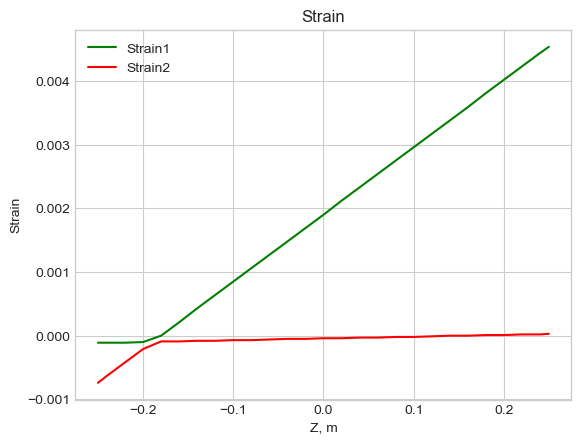

In [34]:
fig = plt.figure()
ax = plt.gca()
df = result1[pr['T'] == 'concrete']
df.plot(kind='line', x='Z', y='Strain1', color='green', ax=ax)
df.plot(kind='line', x='Z', y='Strain2', color='red', ax=ax)
plt.title('Strain')
ax.set_xlabel('Z, m')
ax.set_ylabel('Strain')
plt.show()

## Напряжения

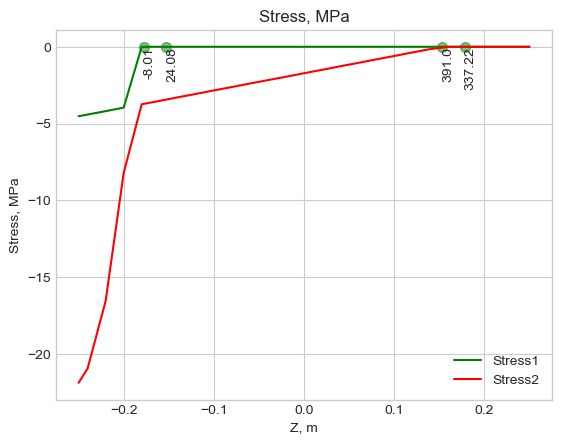

In [35]:
fig = plt.figure()
ax = plt.gca()
df = result1[pr['T'] == 'concrete']
df.plot(kind='line', x='Z', y='Stress1', color='green', ax=ax)
df.plot(kind='line', x='Z', y='Stress2', color='red', ax=ax)
Z = result1.Z[pr['T'] == 'rebar'].values
rstress = result1.Stress1[pr['T'] == 'rebar']
ax.scatter(Z, np.zeros(len(Z)), s=50, c='green', alpha=0.5)
for i, txt in enumerate(rstress):
    ax.annotate(round(txt, 2), (Z[i], 0.0), rotation=90, size=10, xytext=(0, 0), va='top', textcoords='offset points')
plt.title('Stress, MPa')
ax.set_xlabel('Z, m')
ax.set_ylabel('Stress, MPa')
plt.show()

# Проверка

In [36]:
def converg():
    Z = pr['Z'].values
    Sxy = np.vstack((Sxyb, Sxys))
    A = pr['A'].values
    Ff = np.zeros(6)
    n = len(Z)
    for i in range(0, n):
        Ff[0] = Ff[0] + Sxy[i][0] * A[i]
        Ff[1] = Ff[1] + Sxy[i][1] * A[i]
        Ff[2] = Ff[2] + Sxy[i][2] * A[i]
        Ff[3] = Ff[3] + Sxy[i][0] * A[i] * Z[i]
        Ff[4] = Ff[4] + Sxy[i][1] * A[i] * Z[i]
        Ff[5] = Ff[5] + Sxy[i][2] * A[i] * Z[i]
    cvr = np.hstack((Fg.reshape(6, 1), np.round(Ff.reshape(6, 1), 4), u.reshape(6, 1)))
    cvrg = pd.DataFrame(cvr, index=['Nxx', 'Nyy', 'Nxy', 'Mxx', 'Myy', 'Mxy'], columns=['Given', 'Found', 'u'])
    return cvrg

## Сходимость

In [37]:
cvrg = converg()
cvrg.head(np.size(cvrg))

,Given,Found,u
Nxx,-0.10,-0.1004,0.000823
Nyy,0.10,0.1004,0.001038
Nxy,0.00,-0.0000,0.001936
Mxx,0.30,0.3000,0.004849
Myy,0.30,0.3000,0.005995
Mxy,0.05,0.0500,0.010212


# Расчет на все нагрузки

In [38]:
nl = len(loads)
ep = np.zeros((nl, 2))
for iF in range(0, nl):
    Fg = loads.values[iF]/1000
    v01 = v0_1
    eps1,eps2,Sig1,Sig2,Sxyb,Sxys,orientation,strain,stress,eps,Sig,u,i,mes,resmes = itrn(v01)
    min_ = min(min(eps1), min(eps2), min(strain))
    max_ = max(max(eps1), max(eps2), max(strain))
    ep[iF, 0] = round(min_, 6)
    ep[iF, 1] = round(max_, 6)

Convergence L/C 11 did not reached!!!


## Деформации

In [39]:
def strains(result):
    fig = plt.figure()
    ax = plt.gca()
    df = result
    df.plot(kind='line', x=None, y='eps_min', color='green', ax=ax)
    df.plot(kind='line', x=None, y='eps_max', color='red', ax=ax)
    plt.title('Strain')
    ax.set_xlabel('L/C')
    ax.set_ylabel('Strain')
    plt.show()

In [40]:
res = pd.DataFrame(ep, columns=['eps_min', 'eps_max'])
res.head(np.size(res))

,eps_min,eps_max
0,0.000000,0.000000
1,0.000000,0.000998
2,0.000000,0.000815
3,-0.000386,0.000000
4,-0.000482,0.000000
5,-0.000478,0.002185
6,-0.000680,0.003206
7,-0.000477,0.002065
8,-0.000059,-0.000018
9,-0.000736,0.004544


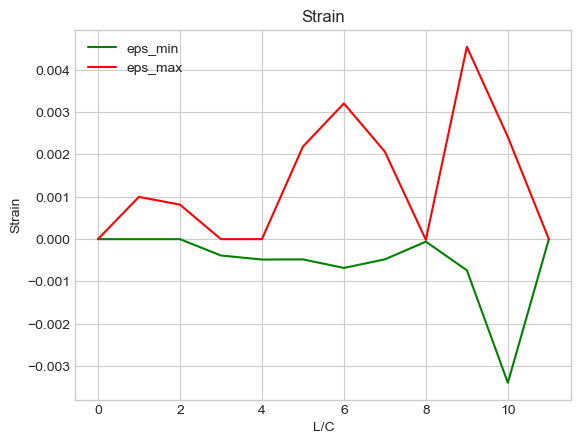

In [41]:
strains(res)